In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib notebook

In [3]:
%matplotlib notebook

NOTES:
the code written before this file: 'command_temporal_order_analysis.ipynb'

To Do: 
The Vector Difference between movement-command activity and mean-command activity (move-mean) vs (shuffle-mean)
Individual Neuron Difference (mean, move, shuffle)
Example: for a chosen command and all shuffle distribution, move distribution, dotted line for global mean.
(The example is a tougher scenario... save till end.  That's because we'd like the activity to be for the same command without matching needed)


In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [5]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


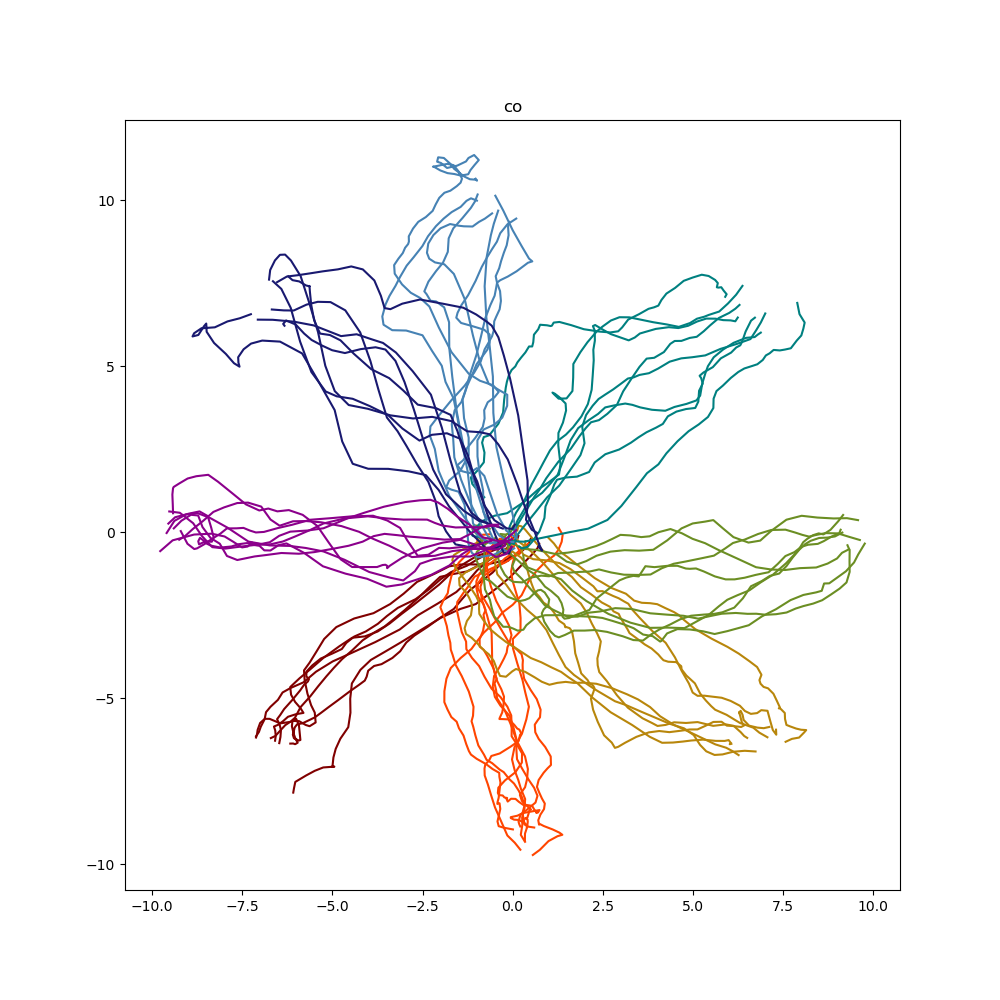

<IPython.core.display.Javascript object>


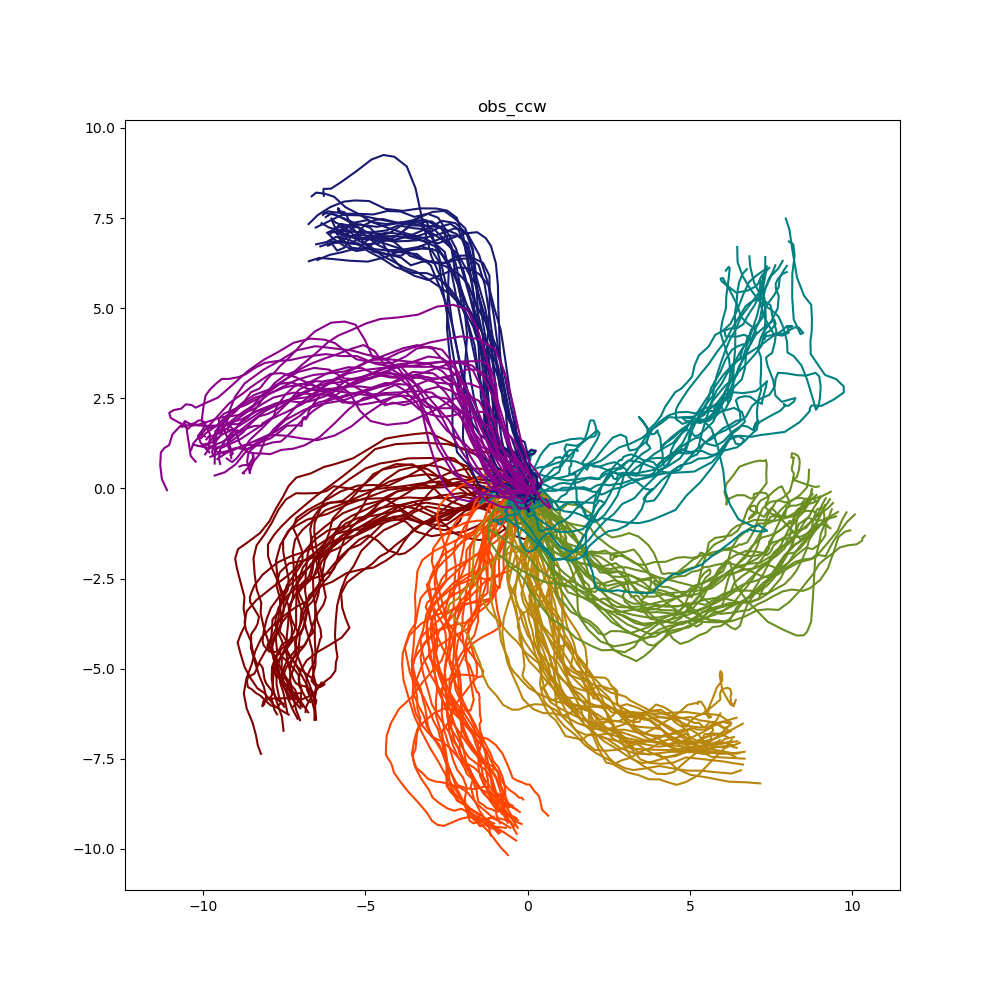

<IPython.core.display.Javascript object>


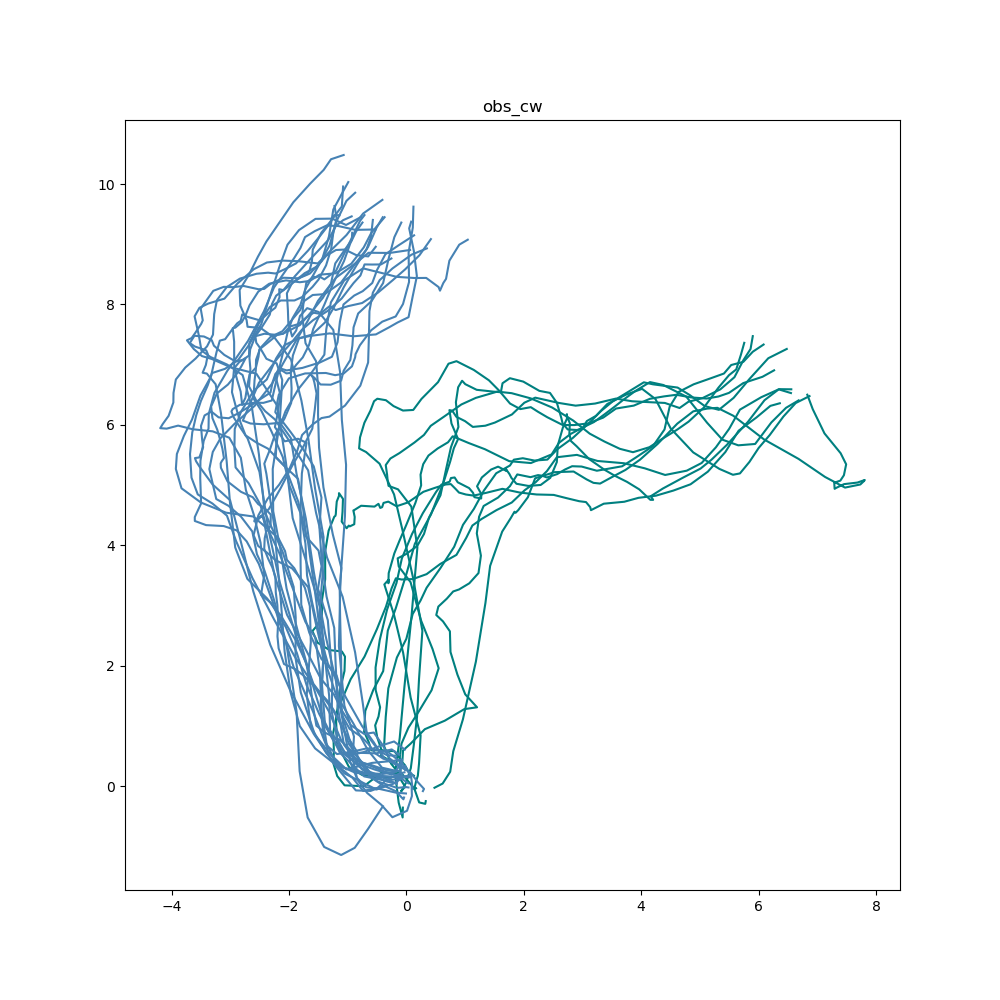

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [13]:
num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)

<IPython.core.display.Javascript object>


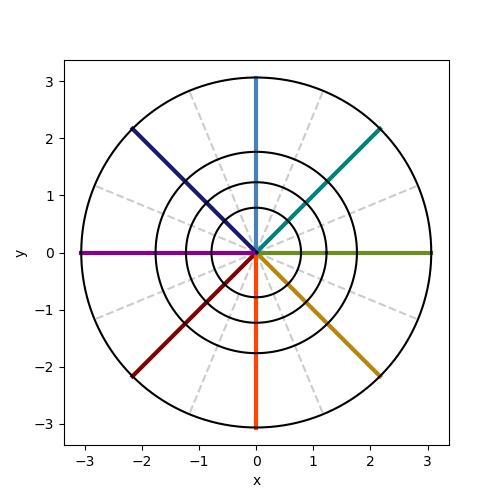

In [14]:
plt.figure(figsize=(5,5))
plot_command_bin()

### Define movement list.  For each command, identify movements which have enough observations of each command.

In [10]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
        
#List of commands in case it's useful    
c_list = []
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
        
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [244]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for c in c_list: 
    bm = c[0]
    ba = c[1]
    
    cm_dic[c] = []
    cm_dic[c,'num_obs'] = []
    #Loop over movement: 
    for m in move_list:
        sel = \
        (df['target']==m[0]) \
        & (df['task_rot']==m[1]) \
        & (df['bin'] >= bin_buffer) \
        & (df['bin_end'] >= bin_buffer) \
        & (df['u_v_mag_bin'] == bm) \
        & (df['u_v_angle_bin'] == ba)
        num_obs = sum(sel)
#             print(bm, ba, m, num_obs)
        #ASSIGN:
        cm_dic[c,m,'sel'] = sel
        cm_dic[c,m,'num_obs'] = num_obs
        if num_obs >= min_obs:
            cm_dic[c].append(m)
            cm_dic[c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for c in c_list:
    bm = c[0]
    ba = c[1]
    cm_dic[c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
    for m in cm_dic[bm,ba]:
        cm_dic[c, 'sel'] = cm_dic[c, 'sel'] \
        | cm_dic[c,m,'sel']
#movement-pool sel wil be useful as the global mean for command-activity.

### For each command, identify the subset of the pool command distribution which matches command mean

In [303]:
#Loop command+movement: 
var = ['u_vx', 'u_vy'] #just to start with 
match_var = var
p_sig = 0.2
max_discard = 150

t_start = timeit.default_timer()

c_list_d = [c_list[10]]
for c in c_list:
    c_idx = df[cm_dic[c,'sel']].index.values
    c_da = bmi_b.df_idx2da(df,c_idx,var)
    cm_list = cm_dic[c]
#     print(cm_list)
#     cm_list_d = [cm_list[0]]
    for m in cm_list:
        cm_idx = df[cm_dic[c,m,'sel']].index.values
        cm_da = bmi_b.df_idx2da(df,cm_idx,var)
        #match distributions:
        d_list=[c_da, cm_da]
        print(c,m)
        success, kept_list, discard_list, df_match, ttest_r, mean_r = bmi_b.subsample_2datasets_to_match_mean_v2(match_var, d_list, p_sig=p_sig, max_iter=max_discard)
        #kept_list: 
        #idx 0: idxs from c_da to keep 
        #idx 1: idxs from cm_da to keep
        
        cm_dic[c,m,'pool_match_idx'] = kept_list[0]
        cm_dic[c,m,'pool_match_success'] = success
        cm_dic[c,m,'pool_match_discard'] = discard_list[0]
        cm_dic[c,m,'pool_match_ttest'] = ttest_r
        cm_dic[c,m,'pool_match_mean'] = mean_r    
        
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed/(60.0*60.0))

((0, 0), (0, 1.1))
matched!
((0, 0), (1, 1.1))
matched!
((0, 0), (2, 1.1))
matched!
((0, 0), (3, 1.1))
matched!
((0, 0), (4, 1.1))
matched!
((0, 1), (0, 1.1))
matched!
((0, 1), (1, 1.1))
matched!
((0, 1), (2, 1.1))
matched!
((0, 1), (3, 1.1))
matched!
((0, 1), (4, 1.1))
matched!
((0, 2), (0, 1.1))
matched!
((0, 2), (1, 0))
matched!
((0, 2), (1, 1.1))
matched!
((0, 2), (2, 0))
matched!
((0, 2), (2, 1.1))
matched!
((0, 2), (3, 1.1))
matched!
((0, 2), (4, 1.1))
matched!
((0, 3), (2, 1.1))
matched!
((0, 3), (3, 1.1))
matched!
((0, 3), (4, 1.1))
matched!
((0, 3), (4, 1.2))
matched!
((0, 3), (5, 1.2))
matched!
((0, 4), (2, 1.1))
matched!
((0, 4), (3, 1.1))
matched!
((0, 4), (4, 1.1))
matched!
((0, 4), (4, 1.2))
matched!
((0, 4), (5, 1.2))
matched!
((0, 5), (2, 1.1))
matched!
((0, 5), (3, 1.1))
matched!
((0, 5), (4, 1.1))
matched!
((0, 5), (4, 1.2))
matched!
((0, 5), (5, 1.2))
matched!
((0, 6), (3, 1.1))
matched!
((0, 6), (4, 1.1))
matched!
((0, 6), (5, 1.2))
matched!
((0, 7), (3, 1.1))
match

### Shuffle movement+time label of each command observation, to serve as a control

In [327]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
t_start = timeit.default_timer()
num_shuffle = 1000
for c in c_list:
    for m in cm_dic[c]:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        num_obs = cm_dic[c,m,'num_obs']
        shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
        for s in range(num_shuffle):
            shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
        #ASSIGN:
        cm_dic[c,m,'shuffle_mat'] = shuffle_mat
t_elapsed = timeit.default_timer()-t_start            

### Implement the analysis of comparing command-activity:

In [39]:
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]

In [366]:
#let's calculate the true vector diff vs shuffle vector diff:
#true mean, shuffle mean, pool-match mean
t_start = timeit.default_timer()
n_list = ['n_'+str(i) for i in range(num_neurons)]
mean_var = copy.copy(n_list)

num_shuffle = 1000

for c in c_list:
    for m in cm_dic[c]:
        print(c,m)
        #POOL:
        c_idxs = cm_dic[c,m,'pool_match_idx']
        mu_c = df.loc[c_idxs, mean_var].mean()
        
        #MOVE:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        mu_cm = df.loc[cm_idxs, mean_var].mean()
        
        #SHUFFLE:
        nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
        s_mean = xr.DataArray(nan_mat, 
                          coords={'v':mean_var,'shuffle':range(num_shuffle)},
                          dims=['v','shuffle'])
        for s in range(num_shuffle):
            s_idxs = cm_dic[c,m,'shuffle_mat'][:,s]
            mu_s = df.loc[s_idxs, mean_var].mean()
            s_mean.loc[:,s] = mu_s
        
        #ASSIGN:
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
        cm_dic[c,m,'n_c'] = mu_c
        cm_dic[c,m,'n_cm'] = mu_cm
        cm_dic[c,m,'n_s'] = s_mean
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)
        

((0, 0), (0, 1.1))
((0, 0), (1, 1.1))
((0, 0), (2, 1.1))
((0, 0), (3, 1.1))
((0, 0), (4, 1.1))
((0, 1), (0, 1.1))
((0, 1), (1, 1.1))
((0, 1), (2, 1.1))
((0, 1), (3, 1.1))
((0, 1), (4, 1.1))
((0, 2), (0, 1.1))
((0, 2), (1, 0))
((0, 2), (1, 1.1))
((0, 2), (2, 0))
((0, 2), (2, 1.1))
((0, 2), (3, 1.1))
((0, 2), (4, 1.1))
((0, 3), (2, 1.1))
((0, 3), (3, 1.1))
((0, 3), (4, 1.1))
((0, 3), (4, 1.2))
((0, 3), (5, 1.2))
((0, 4), (2, 1.1))
((0, 4), (3, 1.1))
((0, 4), (4, 1.1))
((0, 4), (4, 1.2))
((0, 4), (5, 1.2))
((0, 5), (2, 1.1))
((0, 5), (3, 1.1))
((0, 5), (4, 1.1))
((0, 5), (4, 1.2))
((0, 5), (5, 1.2))
((0, 6), (3, 1.1))
((0, 6), (4, 1.1))
((0, 6), (5, 1.2))
((0, 7), (3, 1.1))
((0, 7), (4, 1.1))
((1, 0), (0, 1.1))
((1, 0), (1, 0))
((1, 0), (1, 1.1))
((1, 0), (2, 1.1))
((1, 0), (3, 1.1))
((1, 0), (4, 1.1))
((1, 1), (0, 1.1))
((1, 1), (1, 0))
((1, 1), (1, 1.1))
((1, 1), (2, 1.1))
((1, 1), (3, 1.1))
((1, 1), (4, 1.1))
((1, 2), (0, 1.1))
((1, 2), (1, 0))
((1, 2), (1, 1.1))
((1, 2), (2, 0))
((1, 

### Calculate which command-movement activity is sig different from command-pool activity

In [368]:
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        #Vec Diff: 
        cm_dic[c,m,'n_diff_true'] = cm_dic[c,m,'n_c'] - cm_dic[c,m,'n_cm']
        n_c_rep = np.array(cm_dic[c,m,'n_c'])[...,None]
        cm_dic[c,m,'n_diff_s'] = n_c_rep-cm_dic[c,m,'n_s']
        
        #Norm Diff: 
        cm_dic[c,m,'n_diff_norm_true'] = np.linalg.norm(cm_dic[c,m,'n_diff_true'], axis=0)
        cm_dic[c,m,'n_diff_norm_s'] = np.linalg.norm(cm_dic[c,m,'n_diff_s'], axis=0)
        

### Save Results

In [ ]:
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
save_path = os.path.join(save_dir, 'mean_analysis_shuffle1000.pkl')

with open(save_path, 'wb') as f: 
    data = pickle.dump(cm_dic, f, protocol=pickle.HIGHEST_PROTOCOL)


### Load results

In [ ]:
# Test load the results
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_activity_diff'
save_path = os.path.join(save_dir, 'mean_analysis_shuffle1000.pkl')
with open(save_path, 'rb') as f: 
    test = pickle.load(f)
np.sum(np.array(test['p'])<=0.05)/float(len(test['p']))  


#if you want to use the loaded results: 
use_loaded_results = True
if use_loaded_results:
    cm_dic = test

### Stats

In [ ]:
#Update the stats to have a p-value for each neuron


### Fraction of significant command-movements

<IPython.core.display.Javascript object>


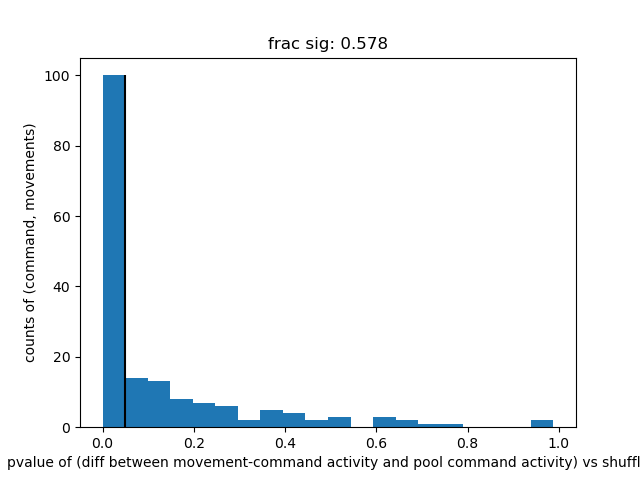

Text(0,0.5,'counts of (command, movements)')

In [372]:
#Count how many shuffle diffs are greater than true diff, and divide by number of shuffles for pval
#TODO: Make a data frame for each (c,m) to store the results
cm_dic['p'] = []
for c in c_list:
    for m in cm_dic[c]:
        num = np.sum(cm_dic[c,m,'n_diff_norm_s']-cm_dic[c,m,'n_diff_norm_true']>0)
        p = float(num)/num_shuffle
        cm_dic[c,m,'p'] = p
        cm_dic['p'].append(p)        
            
p_sig =0.05
frac_sig = float(np.sum(np.array(cm_dic['p'])<=p_sig))/len(cm_dic['p'])

plt.figure()
n,bins,patch=plt.hist(cm_dic['p'],20)
plt.vlines(0.05, 0, n.max() )
plt.title('frac sig: ' + str(round(frac_sig,4)))
plt.xlabel('pvalue of (diff between movement-command activity and pool command activity) vs shuffle')
plt.ylabel('counts of (command, movements)')

In [9]:
#Get the observations of data
mean_var = copy.copy(n_list)
for c in c_list:
    for m in cm_dic[c]:
        cm_sel = cm_dic[c,m,'sel']
        cm_idxs = cm_sel[cm_sel].index.values
        cm_dic[c,m,'mat_df'] = df.loc[cm_idxs, mean_var]

NameError: name 'n_list' is not defined

### Hist/Scatter mean diffs 

In [25]:
num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

### Whole day metric using population vector

In [ ]:
#Metric for the whole day: 
#Compute for true data and average over shuffle (?)
#1) change from global mean
#for each command-movement, do: norm(global_mean-data_mean)
#2) frac change from global mean
#for each command-movement, do: norm(global_mean-data_mean)/(norm(global_mean))

In [16]:
columns = \
['shuffle_diff_norm', 'true_diff_norm', 'global_norm',\
 'command_idx', 'movement_idx',  'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']

df_test = pd.DataFrame(index=[0], columns=columns)

In [17]:
df_test.shape

(1, 11)

In [19]:
c = (0,0)
m = cm_dic[c][0]
cm_dic[c,m,'s_diff_norm_true']

KeyError: ((0, 0), (0, 1.1), 's_diff_norm_true')

In [23]:
np.linalg.norm(cm_dic[c,m,'n_c'])

7.822535541665455

In [45]:
#Make dataframe of results: 
columns = \
['shuffle_diff_norm', 'true_diff_norm', 'global_norm', 'true_frac_diff_norm', 'shuffle_frac_diff_norm', \
 'command_idx', 'movement_idx',  'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']
p_sig = 0.05
r = []

for c in c_list:
    for m in cm_dic[c]:
        diff_df = pd.DataFrame(index=[0],columns=columns)
        
        #RESULTS:
        diff_df.loc[0,'true_diff_norm'] = cm_dic[c,m,'n_diff_norm_true']
        diff_df.loc[0,'shuffle_diff_norm'] = cm_dic[c,m,'n_diff_norm_s'].mean()
        
        diff_df.loc[0,'global_norm'] = np.linalg.norm(cm_dic[c,m,'n_c'])
        diff_df.loc[0,'true_frac_diff_norm'] = cm_dic[c,m,'n_diff_norm_true']/diff_df.loc[0,'global_norm']
        diff_df.loc[0,'shuffle_frac_diff_norm'] = cm_dic[c,m,'n_diff_norm_s'].mean()/diff_df.loc[0,'global_norm']
        
        #RELATED VAR:
        diff_df.loc[0,'command_idx'] = c2idx[c]
        diff_df.loc[0,'movement_idx'] = m2idx[m]
        diff_df.loc[0,'u_v_mag_bin'] = c[0]
        diff_df.loc[0,'u_v_angle_bin'] = c[1]
        diff_df.loc[0,'p'] = cm_dic[c,m,'p']
        diff_df.loc[0,'sig'] = cm_dic[c,m,'p']<=p_sig
        
        r.append(diff_df)

r = pd.concat(r,ignore_index=True)

<IPython.core.display.Javascript object>


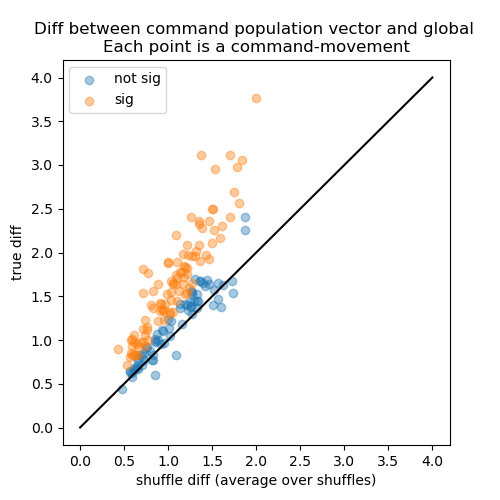

In [62]:
fig_name = 'scatter_vector_diff_true_vs_shuffle'
save_bool = False

# s_nsig = r.loc[:,'shuffle_diff_norm']
# d_nsig = r.loc[:,'true_diff_norm']

bm_sel = r.loc[:, 'u_v_mag_bin'] >=0
extra_sel = bm_sel

sel = (r.loc[:,'sig']==0)&extra_sel
s_nsig = r.loc[sel,'shuffle_diff_norm']
d_nsig = r.loc[sel,'true_diff_norm']

sel = (r.loc[:,'sig']==1)&extra_sel
s_sig = r.loc[sel,'shuffle_diff_norm']
d_sig = r.loc[sel,'true_diff_norm']


plt.figure(figsize=(5,5))
# plt.scatter(s,d,alpha=0.4)
plt.scatter(s_nsig,d_nsig,alpha=0.4, label='not sig')
plt.scatter(s_sig,d_sig,alpha=0.4, label='sig')
plt.legend()
plt.plot([0,4], [0,4],color='k')
plt.xlabel('shuffle diff (average over shuffles)')
plt.ylabel('true diff')
plt.title('Diff between command population vector and global \nEach point is a command-movement')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


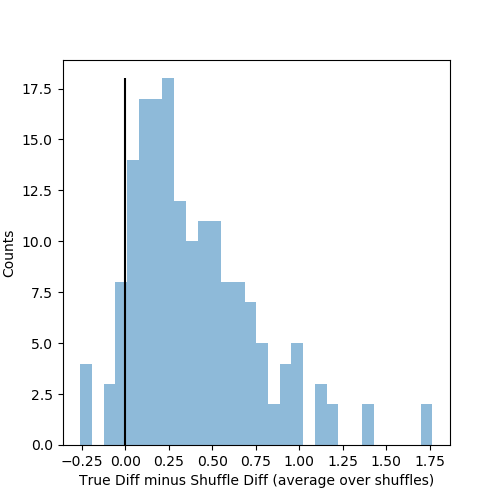

<IPython.core.display.Javascript object>


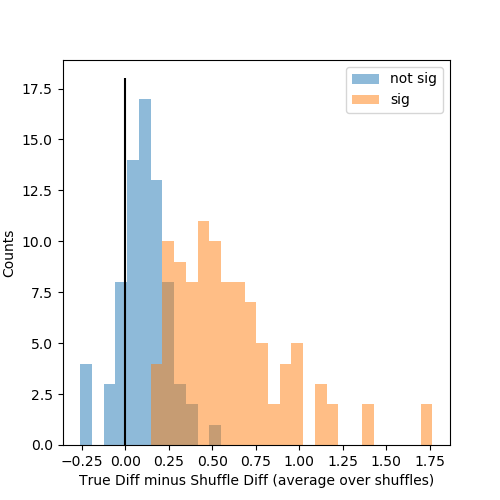

In [105]:
#Histogram of differences
#All and just significant: 


fig_name = 'hist_vector_diff_true_minus_shuffle'
save_bool = True

#ALL DATA:
s = r.loc[:,'shuffle_diff_norm']
d = r.loc[:,'true_diff_norm']
diff_df = d-s
diff=list(d-s)
plt.figure(figsize=(5,5))
n_all,bins,_ = plt.hist(diff,bins=30,alpha=0.5)
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


fig_name = 'hist_vector_diff_true_minus_shuffle_sig'
save_bool = True
        
#NOT SIG and SIG:
sel = (r.loc[:,'sig']==0)
s_nsig = r.loc[sel,'shuffle_diff_norm']
d_nsig = r.loc[sel,'true_diff_norm']
diff_nsig=list(d_nsig-s_nsig)

sel = (r.loc[:,'sig']==1)
s_sig = r.loc[sel,'shuffle_diff_norm']
d_sig = r.loc[sel,'true_diff_norm']
diff_sig = list(d_sig-s_sig)


# bin_e = np.linspace(0,4,41)
plt.figure(figsize=(5,5))
# n_all,bins,_ = plt.hist(diff,bins=20,alpha=0.5)
ig = plt.hist(diff_nsig,bins=bins,alpha=0.5,label='not sig')
ig = plt.hist(diff_sig,bins=bins,alpha=0.5,label='sig')
plt.legend()
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


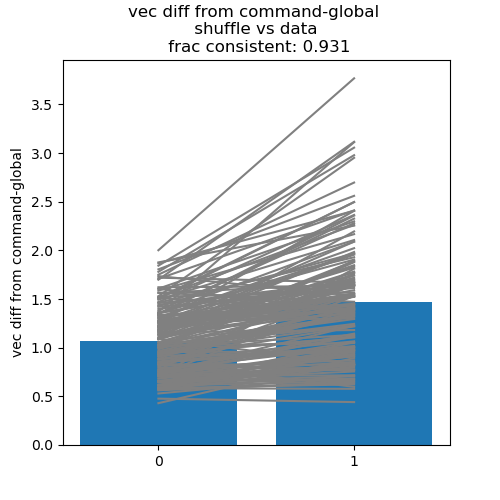

In [147]:
#BAR PLOT: 
fig_name = 'bar_vector_diff_true_vs_shuffle'
save_bool = True

s = np.array(r.loc[:,'shuffle_diff_norm'])
d = np.array(r.loc[:,'true_diff_norm'])
d_plt = np.concatenate((s.reshape(-1,1), d.reshape(-1,1)),axis=1).T

# If you want to see negative vs positive data points:
pos_sel = (d_plt[1,:]-d_plt[0,:])>=0
d_plt_pos = d_plt[:,pos_sel]
neg_sel = (d_plt[1,:]-d_plt[0,:])<0
d_plt_neg = d_plt[:,neg_sel]

frac_consistent = float(sum(pos_sel))/len(d)
#number of data points obeying the trend

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt_pos,color=0.5*np.ones(3))
# _=plt.plot(d_plt_neg,color='r')

_=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])

_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])
plt.ylabel('vec diff from command-global')
plt.title('vec diff from command-global \n shuffle vs data \n frac consistent: ' + str(round(frac_consistent,3)))
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


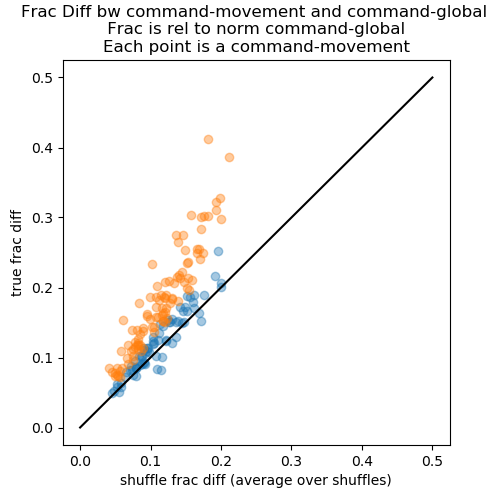

In [57]:
fig_name = 'scatter_vector_frac_diff_true_vs_shuffle'
save_bool = False

# s = r.loc[:,'shuffle_frac_diff_norm']
# d = r.loc[:,'true_frac_diff_norm']

sel = r.loc[:,'sig']==0
s_nsig = r.loc[sel,'shuffle_frac_diff_norm']
d_nsig = r.loc[sel,'true_frac_diff_norm']

sel = r.loc[:,'sig']==1
s_sig = r.loc[sel,'shuffle_frac_diff_norm']
d_sig = r.loc[sel,'true_frac_diff_norm']


plt.figure(figsize=(5,5))
# plt.scatter(s,d,alpha=0.4)
plt.scatter(s_nsig,d_nsig,alpha=0.4, label='not sig')
plt.scatter(s_sig,d_sig,alpha=0.4, label='sig')

plt.plot([0, 0.5], [0,0.5],color='k')
plt.xlabel('shuffle frac diff (average over shuffles)')
plt.ylabel('true frac diff')
plt.title('Frac Diff bw command-movement and command-global \n Frac is rel to norm command-global \nEach point is a command-movement')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


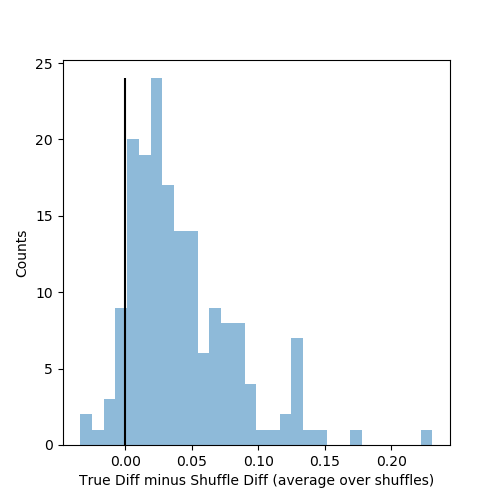

<IPython.core.display.Javascript object>


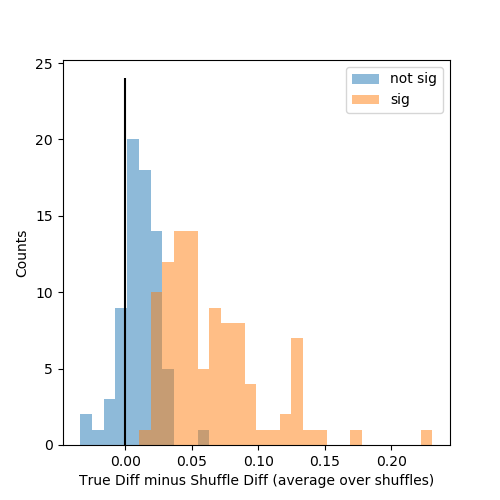

In [107]:
#Histogram of frac differences
#All and just significant: 

#-----------------------------------------------------------------------
fig_name = 'hist_vector_frac_diff_true_minus_shuffle'
save_bool = False

#ALL DATA:
s = r.loc[:,'shuffle_frac_diff_norm']
d = r.loc[:,'true_frac_diff_norm']
diff_df = d-s
diff=list(d-s)
plt.figure(figsize=(5,5))
n_all,bins,_ = plt.hist(diff,bins=30,alpha=0.5)
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)


#-----------------------------------------------------------------------
fig_name = 'hist_vector_frac_diff_true_minus_shuffle_sig'
save_bool = False
        
#NOT SIG and SIG:
sel = (r.loc[:,'sig']==0)
s_nsig = r.loc[sel,'shuffle_frac_diff_norm']
d_nsig = r.loc[sel,'true_frac_diff_norm']
diff_nsig=list(d_nsig-s_nsig)

sel = (r.loc[:,'sig']==1)
s_sig = r.loc[sel,'shuffle_frac_diff_norm']
d_sig = r.loc[sel,'true_frac_diff_norm']
diff_sig = list(d_sig-s_sig)

# bin_e = np.linspace(0,4,41)
plt.figure(figsize=(5,5))
# n_all,bins,_ = plt.hist(diff,bins=20,alpha=0.5)
ig = plt.hist(diff_nsig,bins=bins,alpha=0.5,label='not sig')
ig = plt.hist(diff_sig,bins=bins,alpha=0.5,label='sig')
plt.legend()
plt.vlines(0,0,n_all.max())
plt.xlabel('True Diff minus Shuffle Diff (average over shuffles)')
plt.ylabel('Counts')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


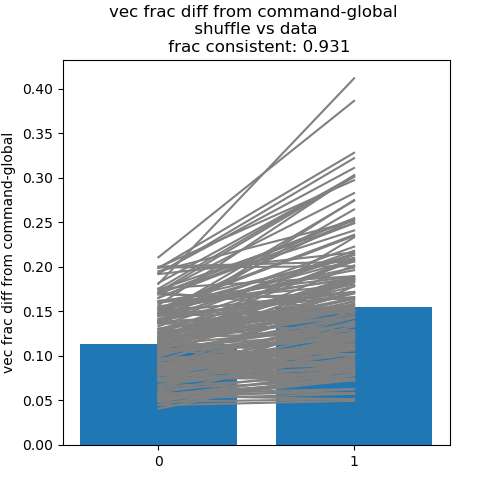

In [145]:
#BAR PLOT: 
fig_name = 'bar_vector_frac_diff_true_vs_shuffle'
save_bool = False

s = np.array(r.loc[:,'shuffle_frac_diff_norm'])
d = np.array(r.loc[:,'true_frac_diff_norm'])
d_plt = np.concatenate((s.reshape(-1,1), d.reshape(-1,1)),axis=1).T

# If you want to see negative vs positive data points:
pos_sel = (d_plt[1,:]-d_plt[0,:])>=0
d_plt_pos = d_plt[:,pos_sel]
neg_sel = (d_plt[1,:]-d_plt[0,:])<0
d_plt_neg = d_plt[:,neg_sel]

frac_consistent = float(sum(pos_sel))/len(d)
#number of data points obeying the trend

plt.figure(figsize=(5,5))
# _=plt.plot(d_plt_pos,color=0.5*np.ones(3))
# _=plt.plot(d_plt_neg,color='r')

_=plt.plot(d_plt,color=0.5*np.ones(3))
plt.bar([0,1], [s.mean(), d.mean()])

_=plt.xticks([0, 1]) #, labels=['shuffle', 'data'])
plt.ylabel('vec frac diff from command-global')
plt.title('vec frac diff from command-global \n shuffle vs data \n frac consistent: ' + str(round(frac_consistent,3)))
# plt.xlim([-1,2])

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

### Within day metric, using individual neurons:

In [ ]:
#TODO: compute p-value on per neuron basis

In [114]:
#histogram the differences of command-movement minus command-mean, for all neurons
#use the matching procedure.
#
# this is analagous to fig3C in jose draft, once we have all the sessions.
#
#Future: could add within movement differences


#Make a dataframe for the results, for each c,m:
#columns: diff, neuron, command_idx, movement_idx, u_v_mag_bin, u_v_angle_bin, task_rot, target
columns = \
['abs_diff', 'diff', 'n_c', 'neuron', 'command_idx', 'movement_idx', \
 'u_v_mag_bin', 'u_v_angle_bin', 'target', 'task_rot', \
 'p','sig']
p_sig = 0.05
r = []
for c in c_list:
    for m in cm_dic[c]:
        diff_n = cm_dic[c,m,'n_diff_true'][n_list]
        abs_diff_a = np.abs(np.array(diff_n)).reshape((-1,1))
        diff_a = np.array(diff_n).reshape((-1,1))
        
        nc_a = np.array(cm_dic[c,m,'n_c'][n_list]).reshape((-1,1))
        
        n_a = np.arange(num_neurons).reshape((-1,1))
        ci_a = (np.ones(num_neurons)*c2idx[c]).reshape((-1,1))
        mi_a = (np.ones(num_neurons)*m2idx[m]).reshape((-1,1))
        mag_a = (np.ones(num_neurons)*c[0]).reshape((-1,1))
        angle_a = (np.ones(num_neurons)*c[1]).reshape((-1,1))
        
        p_a = (cm_dic[c,m,'p']*np.ones(num_neurons)).reshape((-1,1))
        sig_a = ((cm_dic[c,m,'p']<=p_sig)*np.ones(num_neurons)).reshape((-1,1))
        
#         print(m)
        target_a = (np.ones(num_neurons)*m[0]).reshape((-1,1))
        task_a = (np.ones(num_neurons)*m[1]).reshape((-1,1))
        
        diff_a = np.concatenate((abs_diff_a, diff_a, nc_a, n_a, ci_a, mi_a, mag_a, angle_a, target_a, task_a, p_a, sig_a),axis=1)
        diff_df = pd.DataFrame(diff_a, columns=columns)
        
        r.append(diff_df)

r = pd.concat(r,ignore_index=True)

<IPython.core.display.Javascript object>


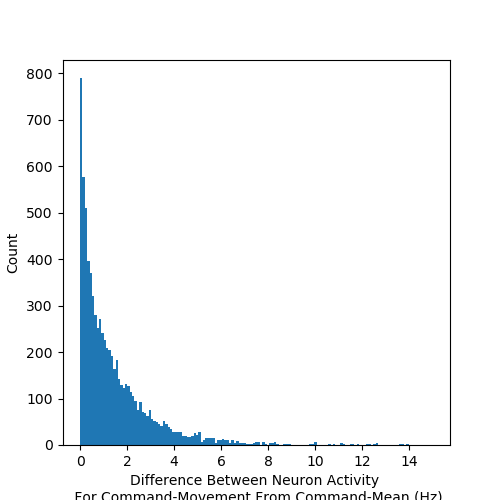

In [103]:
fig_name = 'hist_neuron_diff'
save_bool = False

bmi_sample_period = 0.1 #sec
bin_e = np.linspace(0,15,num=15*10,endpoint=True)
d = r.loc[:,'abs_diff']/bmi_sample_period
plt.figure(figsize=(5,5))
plt.hist(d, bins=bin_e)
plt.xlabel('Difference Between Neuron Activity \n For Command-Movement From Command-Mean (Hz)')
plt.ylabel('Count')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


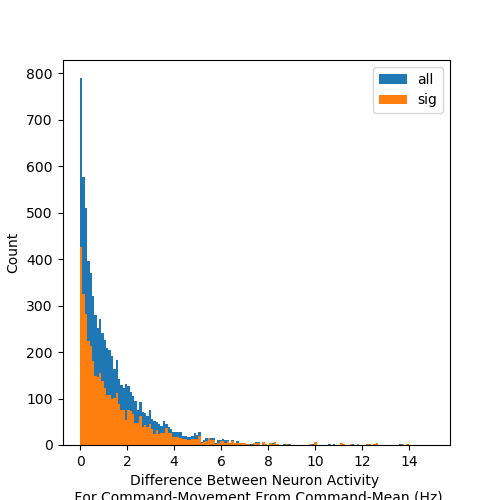

In [111]:
fig_name = 'hist_neuron_diff_all_vs_sig'
save_bool = False

d = r.loc[:,'abs_diff']/bmi_sample_period
w_d = 1.0/len(d)*np.ones(len(d))

sig_sel = r.loc[:,'sig']==1
d_sig = r.loc[sig_sel,'abs_diff']/bmi_sample_period
w_d_sig = 1.0/len(d_sig)*np.ones(len(d_sig))


bmi_sample_period = 0.1 #sec
bin_e = np.linspace(0,15,num=15*10,endpoint=True)

plt.figure(figsize=(5,5))
plt.hist(d, bins=bin_e, label='all')
plt.hist(d_sig, bins=bin_e, label='sig') #alpha, weights



plt.legend()
plt.xlabel('Difference Between Neuron Activity \n For Command-Movement From Command-Mean (Hz)')
plt.ylabel('Count')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

<IPython.core.display.Javascript object>


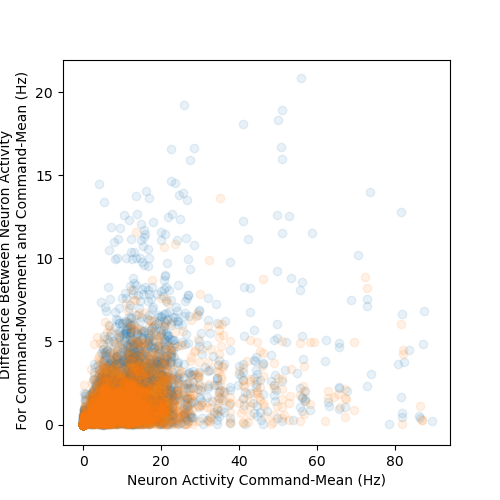

In [127]:
#Scatter command_mean vs diff

fig_name = 'scatter_neuron_command_mean_vs_diff'
save_bool = False
bin_sample_period = 0.1

plt.figure(figsize=(5,5))

#sig:
sel = r.loc[:,'sig']==1
d_cm = r.loc[sel,'n_c']/bmi_sample_period
d_diff = r.loc[sel,'abs_diff']/bmi_sample_period

plt.scatter(d_cm, d_diff,alpha=0.1,label='sig')

#not sig:
sel = r.loc[:,'sig']==0
d_cm = r.loc[sel,'n_c']/bmi_sample_period
d_diff = r.loc[sel,'abs_diff']/bmi_sample_period
plt.scatter(d_cm, d_diff,alpha=0.1,label='not sig')


plt.xlabel('Neuron Activity Command-Mean (Hz)')
plt.ylabel('Difference Between Neuron Activity \n For Command-Movement and Command-Mean (Hz)')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, fig_name+ext)
        plt.savefig(save_path)

In [ ]:
lme_columns = ['activity', 'movement', 'u_vx', 'u_vy', 'kin_px', 'kin_py', 'kin_vx', 'kin_vy', 'group']
df_lme = pd.DataFrame(data=a_lme, index=range(num_samples_expand), columns=lme_columns)

In [30]:
m_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [37]:
c = (0,0)
m = cm_dic[c][0]
cm_dic[c,m,'n_diff_true']

n_0     0.495641
n_1    -0.027397
n_2     0.020548
n_3    -0.018057
n_4    -0.404110
n_5    -0.146326
n_6     0.283313
n_7     0.005604
n_8    -0.038605
n_9    -0.031756
n_10    0.006849
n_11   -0.469489
n_12   -0.031756
n_13    0.000000
n_14   -0.161270
n_15   -0.289539
n_16   -0.077210
n_17   -0.226650
n_18   -0.328144
n_19   -0.038605
n_20   -0.093400
n_21    0.219801
n_22   -0.309465
n_23    0.343711
n_24    0.008717
n_25    0.163761
n_26    0.171233
n_27    0.034869
n_28   -0.321295
n_29    0.069116
n_30    0.353674
n_31    0.107098
n_32    0.163761
n_33   -0.019303
n_34    0.142590
n_35   -0.125778
n_36    0.508717
n_37    0.242839
n_38    0.171856
n_39    0.391034
n_40    0.389788
n_41   -1.655666
n_42   -0.608966
n_43    0.377335
dtype: float64